In [35]:
using Plots, PlutoUI
using StatsPlots
using GenesInteraction
using MLJ
using MLJ: @mlj_model
using Distributions
using StableRNGs
using StatsBase

# Environment initialisation

Loading some models

In [3]:
LogisticClassifier = @load LogisticClassifier pkg=MLJLinearModels verbosity=0
LinearRegressor = @load LinearRegressor pkg=MLJLinearModels verbosity=0
EvoTreeRegressor = @load EvoTreeRegressor pkg=EvoTrees verbosity=0
DecisionTreeRegressor = @load DecisionTreeRegressor pkg=DecisionTree verbosity=0
NeuralNetworkRegressor = @load NeuralNetworkRegressor pkg=MLJFlux verbosity=0
NuSVR = @load NuSVR pkg=LIBSVM verbosity=0
KNNRegressor = @load KNNRegressor pkg=NearestNeighborModels verbosity=0

┌ Info: Precompiling MLJLinearModels [6ee0df7b-362f-4a72-a706-9e79364fb692]
└ @ Base loading.jl:1317
┌ Info: Precompiling MLJDecisionTreeInterface [c6f25543-311c-4c74-83dc-3ea6d1015661]
└ @ Base loading.jl:1317
┌ Info: Precompiling MLJLIBSVMInterface [61c7150f-6c77-4bb1-949c-13197eac2a52]
└ @ Base loading.jl:1317


NearestNeighborModels.KNNRegressor

In [4]:
expit(x) = 1 ./ (1 .+ exp.(-x))

expit (generic function with 1 method)

# Simulation Datasets

## Continuous problems

In [5]:
function continuous_problem(rng;n=100)
    Unif = Uniform(0, 1)
    W = float(rand(rng, Bernoulli(0.5), n, 3))
    t = rand(rng, Unif, n) .< expit(0.5W[:, 1] + 1.5W[:, 2] - W[:,3])
    y = t + 2W[:, 1] + 3W[:, 2] - 4W[:, 3] + rand(rng, Normal(0,1), n)
    # Type coercion
    W = MLJ.table(W)
    t = categorical(t)
    return t, W, y, 1
end

continuous_problem (generic function with 1 method)

## Categorical problems

In [8]:
function categorical_problem(rng;n=100)
    p_w() = 0.3
    pa_given_w(w) = 1 ./ (1 .+ exp.(-0.5w .+ 1))
    py_given_aw(a, w) = 1 ./ (1 .+ exp.(2w .- 3a .+ 1))
    # Sample from dataset
    Unif = Uniform(0, 1)
    w = rand(rng, Unif, n) .< p_w()
    t = rand(rng, Unif, n) .< pa_given_w(w)
    y = rand(rng, Unif, n) .< py_given_aw(t, w)
    # Convert to dataframe to respect the Tables.jl
    # and convert types
    W = (W=convert(Array{Float64}, w),)
    t = categorical(t)
    y = categorical(y)
    # Compute the theoretical ATE
    ATE₁ = py_given_aw(1, 1)*p_w() + (1-p_w())*py_given_aw(1, 0)
    ATE₀ = py_given_aw(0, 1)*p_w() + (1-p_w())*py_given_aw(0, 0)
    ATE = ATE₁ - ATE₀
    
    return t, W, y, ATE
end

function interaction_categorical_problem(rng;n=100)
    μy_fn(W, T₁, T₂) = expit(2W[:, 1] .+ 1W[:, 2] .- 2W[:, 3] .- T₁ .+ T₂ .+ 2*T₁ .* T₂)
    # Sampling W: Bernoulli
    W = rand(rng, Bernoulli(0.5), n, 3)

    # Sampling T₁, T₂ from W: Softmax
    θ = [1 2 -3 -2; 
         -2 4 6 0 ;
         3 -1 -4 2]
    softmax = exp.(W*θₜ) ./ sum(exp.(W*θₜ), dims=2)
    T = [sample(rng, [1, 2, 3, 4], Weights(softmax[i, :])) for i in 1:n]
    T₁ = [t in (1,2) ? true : false for t in T]
    T₂ = [t in (1,3) ? true : false for t in T]

    # Sampling y from T₁, T₂, W: Logistic
    μy = μy_fn(W, T₁, T₂)
    y = [rand(rng, Bernoulli(μy[i])) for i in 1:n]

    # Respect the Tables.jl interface and convert types
    W = MLJ.table(float(W))
    T = (T₁ = categorical(T₁), T₂ = categorical(T₂))
    y = categorical(y)

    # Compute the theoretical ATE
    Wcomb = [1 1 1;
            1 1 0;
            1 0 0;
            1 0 1;
            0 1 0;
            0 0 0;
            0 0 1;
            0 1 1]
    ATE = 0
    for i in 1:8
        w = reshape(Wcomb[i, :], 1, 3)
        temp = μy_fn(w, [1], [1])[1]
        temp += μy_fn(w, [0], [0])[1]
        temp -= μy_fn(w, [1], [0])[1]
        temp -= μy_fn(w, [0], [1])[1]
        ATE += temp*0.5*0.5*0.5
    end
    return T, W, y, ATE
end


interaction_categorical_problem (generic function with 1 method)

# Advantage of using the Stack

In [10]:
n = 10000
p = 3
rng = StableRNG(123)
X = rand(rng, n, p)
y = 3exp.(-X[:, 1].*X[:, 2]) .+ sin.(X[:,2] .- X[:, 3]) .- log.(X[:, 3]);

In [12]:
library = (LinearRegression=LinearRegressor(),
            DecisionTree=DecisionTreeRegressor(),
            Nnet=NeuralNetworkRegressor(),
            KNN=KNNRegressor(),
            NuSVM=NuSVR());

In [14]:
stack = Stack(;metalearner=LinearRegressor(), 
            resampling=CV(;nfolds=5), 
            library...);

In [15]:
all_models = (MyStack=stack, library...)
Xtable = MLJ.table(X)
measurements = []
modelnames = []
for (modelname, model) in zip(keys(all_models), all_models)
    mach = machine(model, Xtable, y)
    res = evaluate!(mach; resampling=Holdout(), measure=rmse)
    push!(measurements, res.measurement[1])
    push!(modelnames, string(modelname))
end

┌ Info: Precompiling GR_jll [d2c73de3-f751-5644-a686-071e5b155ba9]
└ @ Base loading.jl:1317


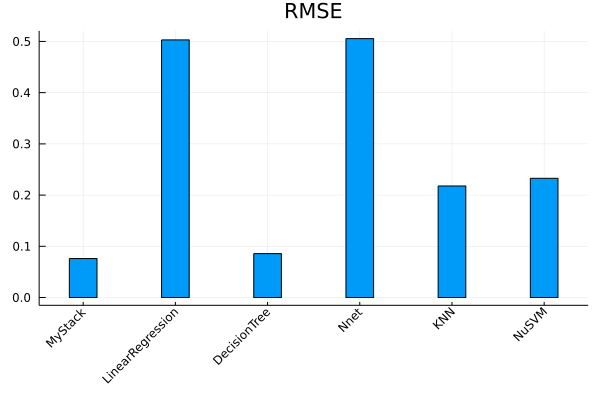

In [16]:
bar(modelnames, measurements, title="RMSE", xrotation=45, bar_width = 0.3, legend=false)

# Demonstrating some properties of TMLE: ATE

In [17]:
function build_estimator(estim_type, cond_target_estim, cond_treat_estim, problem)
    family = nothing
    if occursin("categorical", string(problem))
        family = Bernoulli()
    elseif occursin("continuous", string(problem))
        family = Normal()
    else
        error("Not recognised problem")
    end
    return estim_type(cond_target_estim, cond_treat_estim, family)
end

function asymptotics(estim_type, cond_target_estim, cond_treat_estim, problem, ns;v=0)
    estimator = build_estimator(estim_type, 
                                cond_target_estim, 
                                cond_treat_estim, 
                                problem)
    estimates = []
    std_errors = []
    truth = []
    for n in ns
        rng = StableRNG(n)
        T, W, y, ATE = problem(rng;n=n)
        fitresult, cache, report = MLJ.fit(estimator, v, T, W, y)
        push!(estimates, fitresult.estimate)
        push!(std_errors, fitresult.stderror)
        push!(truth, ATE)
    end
    estimates, std_errors, truth
end

function multirun(estim_type, cond_target_estim, cond_treat_estim, problem;v=0, nruns=1000, pbsize=1000)
    estimator = build_estimator(estim_type, 
                                cond_target_estim, 
                                cond_treat_estim, 
                                problem)
    estimates = []
    ATE = 0
    rng = StableRNG(pbsize)
    for i in 1:nruns
        T, W, y, ATE = problem(rng;n=pbsize)
        fitresult, cache, report = MLJ.fit(estimator, v, T, W, y)
        push!(estimates, fitresult.estimate)
    end
    estimates, ATE
end

multirun (generic function with 1 method)

## Double Robustness of the ATE estimator

In [19]:
Ns = convert(Vector{Int}, [1e2, 5e2, 1e3, 5e3, 1e4, 5e4, 1e5, 5e5, 1e6]);

In [23]:
cat_estimates₁, cat_stderrors₁, cat_truth₁ = asymptotics(ATEEstimator, ConstantClassifier(), ConstantClassifier(), categorical_problem, Ns;v=0)
cat_estimates₂, cat_stderrors₂, cat_truth₂ = asymptotics(ATEEstimator, LogisticClassifier(), ConstantClassifier(), categorical_problem, Ns;v=0)
cat_estimates₃, cat_stderrors₃, cat_truth₃ = asymptotics(ATEEstimator, ConstantClassifier(), LogisticClassifier(), categorical_problem, Ns;v=0)
cat_estimates₄, cat_stderrors₄, cat_truth₄ = asymptotics(ATEEstimator, LogisticClassifier(), LogisticClassifier(), categorical_problem, Ns;v=0);

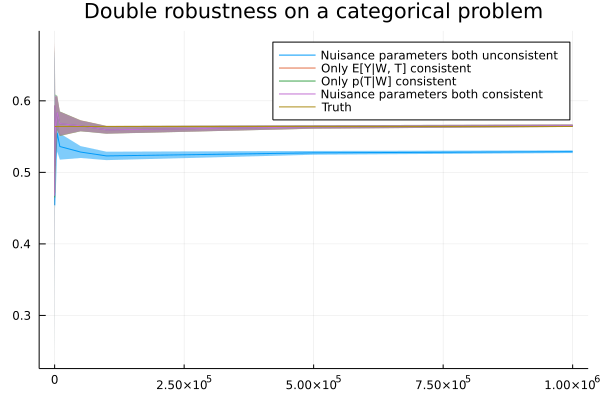

In [21]:
plot(Ns, cat_estimates₁, ribbon=1.98*cat_stderrors₁, 
    label="Nuisance parameters both unconsistent", 
    title="Double robustness on a categorical problem",
    legend=:best)
plot!(Ns, cat_estimates₂, ribbon=1.98*cat_stderrors₂, label="Only E[Y|W, T] consistent")
plot!(Ns, cat_estimates₃, ribbon=1.98*cat_stderrors₃, label="Only p(T|W] consistent")
plot!(Ns, cat_estimates₄, ribbon=1.98*cat_stderrors₄, label="Nuisance parameters both consistent")
plot!(Ns, cat_truth₁, label="Truth")

In [24]:
cont_estimates₁, cont_stderrors₁, cont_truth₁ = asymptotics(ATEEstimator, MLJ.DeterministicConstantRegressor(), ConstantClassifier(), continuous_problem, Ns;v=0)
cont_estimates₂, cont_stderrors₂, cont_truth₂ = asymptotics(ATEEstimator, LinearRegressor(), ConstantClassifier(), continuous_problem, Ns;v=0)
cont_estimates₃, cont_stderrors₃, cont_truth₃ = asymptotics(ATEEstimator, MLJ.DeterministicConstantRegressor(), LogisticClassifier(), continuous_problem, Ns;v=0)
cont_estimates₄, cont_stderrors₄, cont_truth₄ = asymptotics(ATEEstimator, LinearRegressor(), LogisticClassifier(), continuous_problem, Ns;v=0);

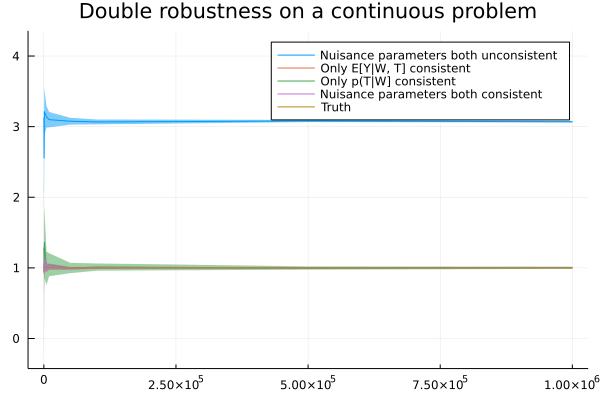

In [25]:
plot(Ns, cont_estimates₁, ribbon=1.98*cont_stderrors₁, 
    label="Nuisance parameters both unconsistent", 
    title="Double robustness on a continuous problem",
    legend=:best)
plot!(Ns, cont_estimates₂, ribbon=1.98*cont_stderrors₂, label="Only E[Y|W, T] consistent")
plot!(Ns, cont_estimates₃, ribbon=1.98*cont_stderrors₃, label="Only p(T|W] consistent")
plot!(Ns, cont_estimates₄, ribbon=1.98*cont_stderrors₄, label="Nuisance parameters both consistent")
plot!(Ns, cont_truth₁, label="Truth")

## Normality of the ATE estimator

In [27]:
estimates, truth = multirun(ATEEstimator, 
                            LogisticClassifier(), 
                            LogisticClassifier(), 
                            categorical_problem;
                            v=0, nruns=10000, pbsize=1000);

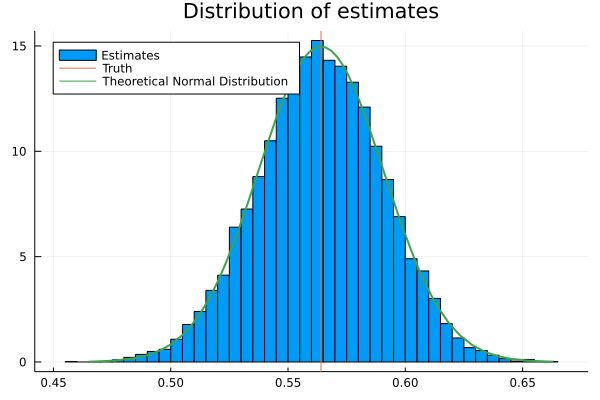

In [30]:
histogram(estimates, 
    title="Distribution of estimates", 
    label="Estimates",
    normalize=true,
    legend=:topleft)
plot!([truth];
    seriestype = :vline, 
    label="Truth")
plot!(Normal(truth, std(estimates)), lw = 2, 
    label="Theoretical Normal Distribution")

# Demonstrating some properties of TMLE: Interaction ATE

Defining some more models

In [41]:
mutable struct InteractionTransformer <: Static end

function MLJ.transform(a::InteractionTransformer, _, X)
    Xmatrix = MLJ.matrix(X)
    nrows, ncols = size(Xmatrix)
    Xinteracts = Matrix{Float64}(undef, nrows, ncols*(ncols-1))
    i = 0
    for col₁ in 1:ncols
        for col₂ in 1:ncols
            if col₁!= col₂  
                i += 1
                Xinteracts[:, i] = Xmatrix[:, col₁] .* Xmatrix[:, col₂]
            end
        end
    end
    return MLJ.table(hcat(Xmatrix, Xinteracts))
end


mutable struct FixedMultinomialRegression <: Probabilistic
    coefs
    classes
end

FixedMultinomialRegression() = FixedMultinomialRegression([1 2 -3 -2; 
                                                           -2 4 6 0 ;
                                                            3 -1 -4 2], 
                                                            [1, 2, 3, 4])

function MLJ.fit(m::FixedMultinomialRegression, v::Int, X, y)
    return nothing,nothing, nothing
end

function MLJ.predict(m::FixedMultinomialRegression, fitresult, Xnew)
    Xmat = MLJ.matrix(Xnew)
    softmax = exp.(Xmat*m.coefs) ./ sum(exp.(Xmat*m.coefs), dims=2)
    return MLJ.UnivariateFinite(m.classes, softmax)
end

In [ ]:
inter_estimates₁, inter_stderrors₁, inter_truth₁ = asymptotics(ATEEstimator, ConstantClassifier(), ConstantClassifier(), categorical_problem, Ns;v=0)
inter_estimates₂, inter_stderrors₂, inter_truth₂ = asymptotics(ATEEstimator, LogisticClassifier(), ConstantClassifier(), categorical_problem, Ns;v=0)
inter_estimates₃, inter_stderrors₃, inter_truth₃ = asymptotics(ATEEstimator, ConstantClassifier(), LogisticClassifier(), categorical_problem, Ns;v=0)
inter_estimates₄, inter_stderrors₄, inter_truth₄ = asymptotics(ATEEstimator, LogisticClassifier(), LogisticClassifier(), categorical_problem, Ns;v=0);